In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [52]:
#importing libraries
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


# 1. Exploratory Analysis

In [53]:
# Reading the input from folder
master_df = pd.read_csv(r"/content/sample30.csv")
df=master_df.copy()
df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


In [54]:
### Total reviews
total = len(df['reviews_text'])
print ("Number of reviews: ",total)

### How many unique reviewers?
print ("Number of unique reviewers: ",len(df['reviews_username'].unique()))
reviewer_prop = float(len(df['reviews_username'].unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))

### Average star score
print ("Average rating score: ",round(df['reviews_rating'].mean(),3))

Number of reviews:  30000
Number of unique reviewers:  24915
Prop of unique reviewers:  0.831
Average rating score:  4.483


In [55]:
#data overivew
print('rows: ', df.shape[0])
print('columns: ', df.shape[1])
print('\nfeatures: ', df.columns.to_list())
print('\nMissing values: ', df.isnull().values.sum())
print('\nUnique values: \n', df.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

Missing values:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

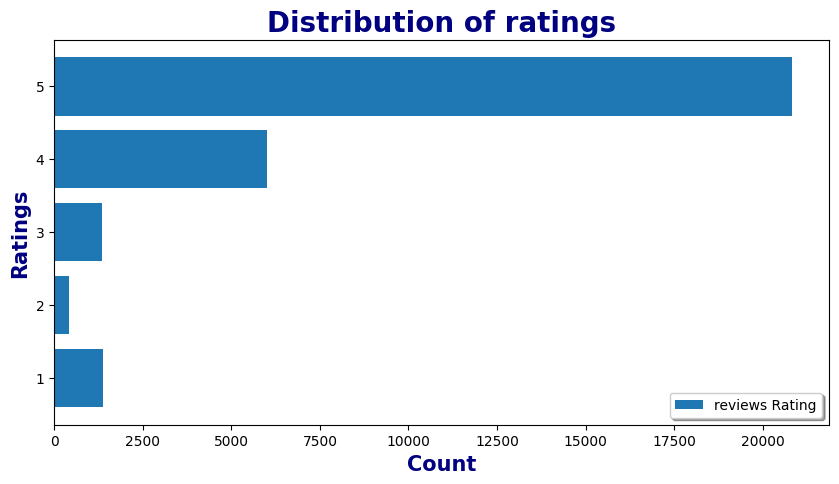

In [57]:
# Number of occurences for each rating
#plot ratings frequency
plt.figure(figsize=[10,5]) #[width, height]
x = list(df['reviews_rating'].value_counts().index)
y = list(df['reviews_rating'].value_counts())
plt.barh(x, y)

plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='navy')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.legend(['reviews Rating'], shadow=True, loc=4)

In [58]:
df['reviews_didPurchase'].fillna("No Data", inplace=True)

In [59]:
df['reviews_didPurchase'].value_counts()

,count
reviews_didPurchase,
False,14498
No Data,14068
True,1434


In [60]:
df['reviews_didPurchase'] = df['reviews_didPurchase'].map({True: 1, False: 0, 'No Data': 2})

<ipython-input-61-448ff387306a>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




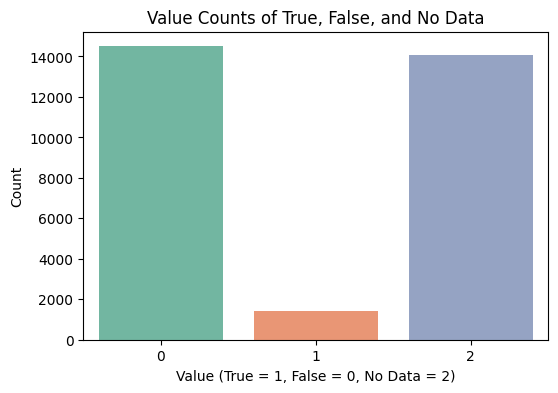

In [61]:
plt.figure(figsize=(6, 4))
sns.countplot(x='reviews_didPurchase', data=df, palette='Set2')

# Customize the plot (optional)
plt.title('Value Counts of True, False, and No Data')
plt.xlabel('Value (True = 1, False = 0, No Data = 2)')
plt.ylabel('Count')

# Show the plot
plt.show()

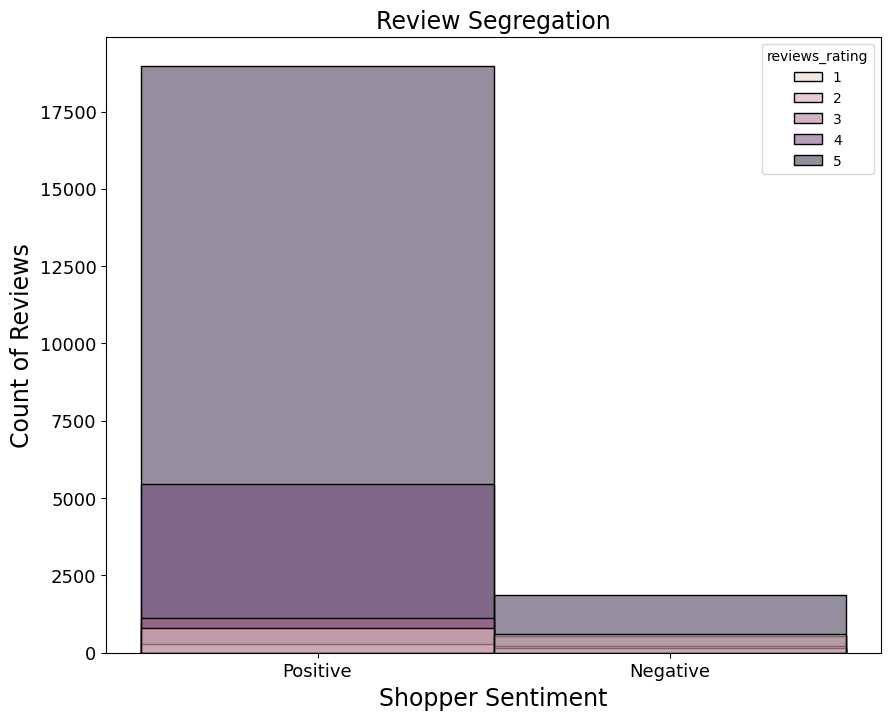

In [62]:
plt.figure(figsize=(10,8))
ax = sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
ax.set_xlabel(xlabel="Shopper Sentiment", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Review Segregation', fontsize=17)
ax.tick_params(labelsize=13)

In [63]:
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [ ]:
# To download the stopwords from NLTK library
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# To Check the most word occurence using word cloud
from wordcloud import WordCloud ,STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(df['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

# 2. Data Cleaning

In [ ]:
# Finding the number of rows with Null values
df.isnull().sum()

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,0
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


In [ ]:
#shape of the dataframe
df.shape

(30000, 15)

In [ ]:
#From the null values percentages, columns reviews_userCity and reviews_userProvince can be dropped
df = df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)

In [ ]:
df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,1,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,1,NaN,5,Good flavor.,Good,dorothy w,Positive


In [ ]:
# Finding the Percentage of rows with Null values
print("shape of the dataframe =",df.shape)
df.isnull().sum()*100/len(df)

shape of the dataframe = (30000, 13)


,0
id,0.000000
brand,0.000000
categories,0.000000
manufacturer,0.470000
name,0.000000
reviews_date,0.153333
reviews_didPurchase,0.000000
reviews_doRecommend,8.566667
reviews_rating,0.000000
reviews_text,0.000000


In [ ]:
# Before Updating the user sentiment columns
df['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [ ]:
# for correcting the user sentiment according to rating
def review_sentiment_clear(x):
  if x >= 3 :
    return 'Postive'
  elif x > 0 and x < 3  :
    return 'Negative'

In [ ]:
df['user_sentiment'] = df['reviews_rating'].apply(review_sentiment_clear)

In [ ]:
df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Postive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,1,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Postive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,1,NaN,5,Good flavor.,Good,dorothy w,Postive


In [ ]:
# After corrections for user sentiment
df['user_sentiment'].value_counts()

,count
user_sentiment,
Postive,28196
Negative,1804


# 3. Text Preprocessing

### Text lower cased , removed Special Charater and lemmatized

In [ ]:
#Common functions for cleaning the text data
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import html

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# special_characters removal
def remove_special_characters(text, remove_digits=True):
    """Remove the special Characters"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

stopword_list= stopwords.words('english')

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas


In [ ]:
def normalize_and_lemmaize(input_text):
    input_text = remove_special_characters(input_text)
    words = nltk.word_tokenize(input_text)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [ ]:
# Take the Review comment and user sentiment as dataframe
review_df = df[['reviews_text','user_sentiment']]
review_df.head(3)

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,Postive
1,Good flavor. This review was collected as part...,Postive
2,Good flavor.,Postive


In [ ]:
# create a new column lemmatized_review using the lemmatize_text function
review_df['lemmatized_text'] = review_df['reviews_text'].map(lambda text: normalize_and_lemmaize(text))
review_df.head(3)

<ipython-input-31-9a696e9db49f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reviews_text,user_sentiment,lemmatized_text
0,i love this album. it's very good. more to the...,Postive,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,Postive,good flavor review collect part promotion
2,Good flavor.,Postive,good flavor


In [ ]:
# new dataframe with lemmatized text and user sentiment
review_new_df = review_df[['lemmatized_text','user_sentiment']]
review_new_df.head(3)

,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound...,Postive
1,good flavor review collect part promotion,Postive
2,good flavor,Postive


In [ ]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [ ]:
getMostCommonWords(review_new_df['lemmatized_text'],10)

NameError: name 'Counter' is not defined

In [ ]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(review_new_df['lemmatized_text'], 2, 10)
pd.DataFrame(common_words)

In [ ]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(review_new_df['lemmatized_text'], 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [ ]:
#Encode the negative and postive to 0 and 1 respectively
review_new_df['user_sentiment'] = review_new_df['user_sentiment'].map({'Negative':0,'Postive':1})
review_new_df.head()

<ipython-input-35-6d6bf15b2db6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound...,1
1,good flavor review collect part promotion,1
2,good flavor,1
3,read review look buy one couple lubricants ult...,0
4,husband buy gel us gel cause irritation felt l...,0


## Dividing the dataset into train and test data and handle the class imbalance

In [ ]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
# Train and Test Divide
x_train,x_test,y_train,y_test = train_test_split(review_new_df['lemmatized_text'],review_new_df['user_sentiment'],train_size=0.75,random_state=45,stratify=review_new_df['user_sentiment'])
y_train.value_counts()

,count
user_sentiment,
1,21147
0,1353


In [ ]:
x_train.head(3)

,lemmatized_text
27324,kid enjoy high energy movie new adventure old ...
11945,make clean kitchen easy never worry counter cl...
7026,like clean power clorax products whiten clothe...


In [ ]:
x_train=pd.DataFrame(x_train)
y_train=pd.DataFrame(y_train)
x_test=pd.DataFrame(x_test)
y_test=pd.DataFrame(y_test)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train['lemmatized_text'])  # Fit on your text column

# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(x_train['lemmatized_text'])
sequences_test = tokenizer.texts_to_sequences(x_test['lemmatized_text'])

# Padding sequences
max_length = max(len(seq) for seq in sequences_train + sequences_test)
x_train_pad = pad_sequences(sequences_train, maxlen=200)
x_test_pad = pad_sequences(sequences_test, maxlen=200)


In [ ]:
import numpy as np
x_train_pad=np.array(x_train_pad)
x_test_pad=np.array(x_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [64]:
# Define LSTM model
def create_lstm_model():
    model = Sequential()

    # Embedding layer (you can load pre-trained embeddings here, e.g., GloVe)
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))

    # LSTM layer with regularization
    model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Dropout regularization

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [65]:
lstm_model = create_lstm_model()

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss to prevent overfitting
    patience=3,           # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore best model state after stopping
)


In [ ]:
x_train_pad

array([[   0,    0,    0, ..., 1402,   42,  227],
       [   0,    0,    0, ...,   67,  152,   21],
       [   0,    0,    0, ...,    7,    5,    8],
       ...,
       [   0,    0,    0, ...,    7,    5,    8],
       [   0,    0,    0, ...,    6,   17,   10],
       [   0,    0,    0, ...,  487,   15,  350]], dtype=int32)

In [ ]:
y_train.shape

(22500, 1)

In [66]:
# Train the model with EarlyStopping
history=lstm_model.fit(x_train_pad, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
282/282 [==============================] - 72s 248ms/step - loss: 0.4498 - accuracy: 0.9382 - val_loss: 0.2154 - val_accuracy: 0.9409
Epoch 2/20
282/282 [==============================] - 69s 244ms/step - loss: 0.1382 - accuracy: 0.9623 - val_loss: 0.1146 - val_accuracy: 0.9664
Epoch 3/20
282/282 [==============================] - 69s 245ms/step - loss: 0.0902 - accuracy: 0.9734 - val_loss: 0.1096 - val_accuracy: 0.9682
Epoch 4/20
282/282 [==============================] - 69s 243ms/step - loss: 0.0742 - accuracy: 0.9792 - val_loss: 0.1186 - val_accuracy: 0.9662
Epoch 5/20
282/282 [==============================] - 69s 245ms/step - loss: 0.0599 - accuracy: 0.9830 - val_loss: 0.1206 - val_accuracy: 0.9611
Epoch 6/20
282/282 [==============================] - 69s 244ms/step - loss: 0.0528 - accuracy: 0.9864 - val_loss: 0.1345 - val_accuracy: 0.9638


In [67]:
# Save the trained LSTM model
lstm_model.save('lstm_sentiment_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



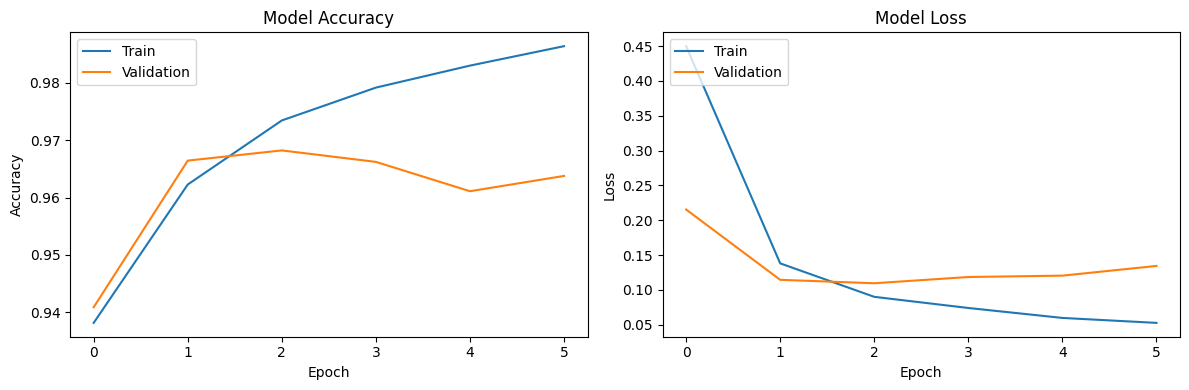

In [68]:
import matplotlib.pyplot as plt

# Assuming 'history' is the returned object from model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


235/235 [==============================] - 16s 67ms/step


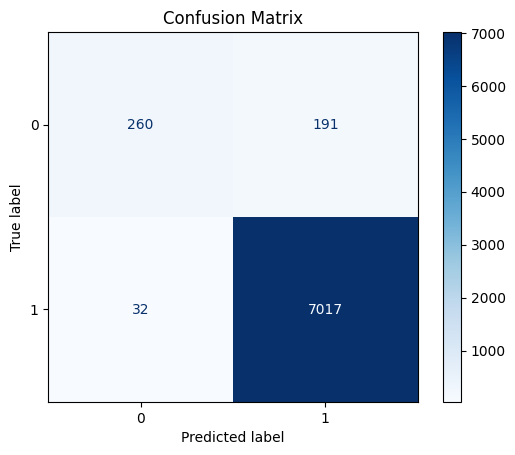

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming 'y_test' are true labels and 'y_pred' are predictions from your model
y_pred = lstm_model.predict(x_test_pad)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

# Plot confusion matrix
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [70]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.58      0.70       451
     Class 1       0.97      1.00      0.98      7049

    accuracy                           0.97      7500
   macro avg       0.93      0.79      0.84      7500
weighted avg       0.97      0.97      0.97      7500



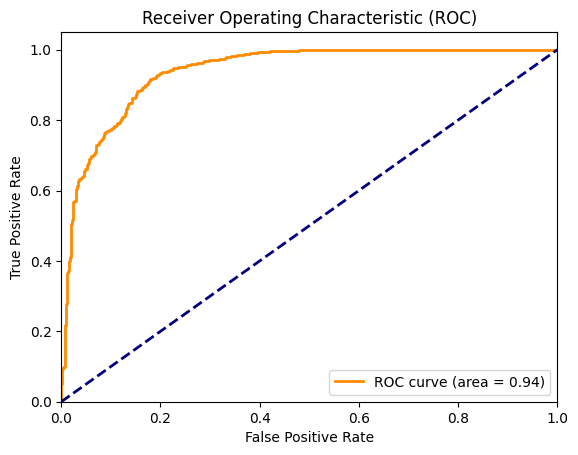

In [71]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


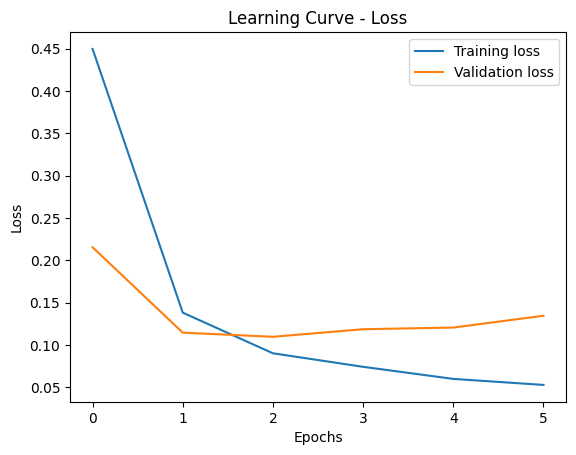

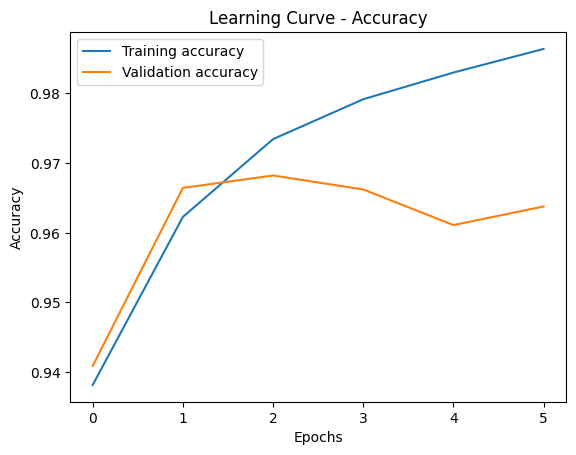

In [72]:
# Learning Curve for Loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Learning Curve for Accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


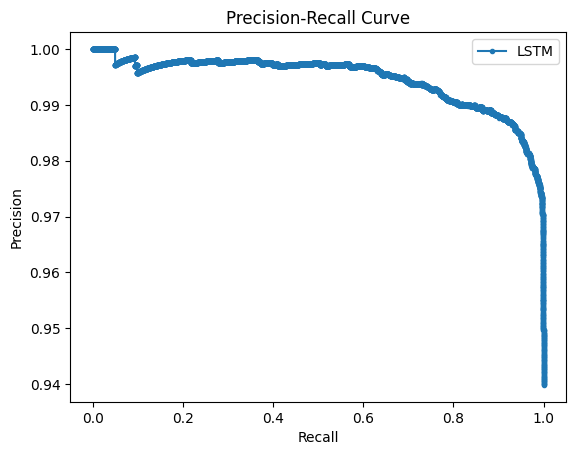

In [73]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, marker='.', label='LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [74]:
with open('evaluation_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)
    f.write(f"\nAUC: {roc_auc}\n")


In [75]:
# Save the trained LSTM model
lstm_model.save('lstm_sentiment_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [76]:
lstm_model.save_weights('lstm_weights.h5')

In [77]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


# 5. Recommedation system
* User and User recommedation system
* Item and Item recommedation system

### User and User recommedation

In [ ]:
df = pd.read_csv('/content/sample30.csv')
df.sample(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28840,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-10T00:00:00.000Z,False,False,2,"This conditioner is fine, unremarkable, but no...",Works fine- not overly impressed,NaN,NaN,mackdepp,Positive
29849,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-20T00:00:00.000Z,False,True,5,I received this product and L'Oral Extraordina...,Excellent!,NaN,NaN,jwolfe216,Positive
222,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-26T00:00:00.000Z,False,True,5,"Great cream, smooth texture, non greasy, hydra...",Loving this,NaN,NaN,dubba,Positive


In [ ]:
len(df['name'].unique())

271

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.70,random_state=45)
print('train shape = ',train.shape)
print('test shape = ',test.shape)

train shape =  (21000, 15)
test shape =  (9000, 15)


In [ ]:
#using train dataset and create correlation matrix
train_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)
train_pivot

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zwithanx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zxcsdfd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#Creating the train and test dataset for predicting and evaluating the correlation
#fill 1 in place of Nan for prediction
train_pivot1 = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)

In [ ]:
train_pivot1.loc['piggyboy420']

,piggyboy420
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0
100:Complete First Season (blu-Ray),1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0
...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0
Weleda Everon Lip Balm,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0


In [ ]:
# here we are going use the adjusted cosine similarity
import numpy as np

def cosine_similarity(df):
    # using the adjusted cosine similarity
    mean_df = np.nanmean(df,axis=1)
    substracted_df = (df.T - mean_df).T # Normalized dataset
    # using the pairwise_distance for cosine similarity
    user_correlation = 1- pairwise_distances (substracted_df.fillna(0),metric='cosine')
    user_correlation[np.isnan(user_correlation)] = 0
    return user_correlation,substracted_df

In [ ]:
user_corr_matrix,normalized_df = cosine_similarity(train_pivot1)
user_corr_matrix

array([[ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       ...,
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ]])

In [ ]:
user_corr_matrix.shape

(18205, 18205)

In [ ]:
user_corr_matrix[user_corr_matrix < 0] = 0
user_corr_matrix.shape

(18205, 18205)

In [ ]:
df[df['reviews_username'] == 'zzz1127']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
7256,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-03T00:00:00.000Z,False,True,4,These wipes are very handy for getting your cl...,Handy Wipes for Quick Cleaning,NaN,NaN,zzz1127,Positive


In [ ]:
user_pred_ratings = np.dot(user_corr_matrix,train_pivot1.fillna(0))
user_pred_ratings

array([[ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       ...,
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386]])

In [ ]:
user_pred_ratings.shape

(18205, 254)

In [ ]:
user_final_rating = np.multiply(user_pred_ratings,train_pivot)
user_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,437.755764,438.269950,437.755764,437.755764,440.056019,437.755764,437.755764,437.755764,437.755764,441.303557,...,437.755764,437.755764,437.755764,437.755764,438.873393,437.755764,437.755764,443.401427,440.056019,437.755764
02dakota,2120.116945,2138.773779,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2133.045416,...,2120.116945,2120.116945,2121.985285,2120.116945,2122.191680,2120.116945,2120.116945,2132.788492,2120.116945,2121.985285
02deuce,2120.116945,2138.773779,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2120.116945,2133.045416,...,2120.116945,2120.116945,2121.985285,2120.116945,2122.191680,2120.116945,2120.116945,2132.788492,2120.116945,2121.985285
0325home,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
06stidriver,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,456.106425,458.597546,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,461.356739,...,457.883951,456.106425,456.106425,456.106425,456.106425,456.106425,456.106425,459.712962,456.106425,456.106425
zwithanx,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525
zxcsdfd,5461.346525,5465.564315,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5465.138556,...,5469.987314,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5461.346525,5467.893332,5464.169357,5461.346525


In [ ]:
# Creating a pickle file for user-user recommendation system
import pickle
pickle.dump(user_final_rating,open('user_final_rating.pkl','wb'))

# Evaluation for user-user recommendation system

In [ ]:
## Evaluation
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2006, 15)

In [ ]:
corr_df = pd.DataFrame(user_corr_matrix)

In [ ]:
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18201,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18202,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18203,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
corr_df['user_name'] = normalized_df.index
corr_df.set_index('user_name',inplace=True)
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
user_name,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zwithanx,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
zxcsdfd,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
list_name = common.reviews_username.tolist()
corr_df.columns = normalized_df.index.tolist()
corr_df.columns

Index(['00sab00', '02dakota', '02deuce', '0325home', '06stidriver', '1.11E+24',
       '1085', '10ten', '11111111aaaaaaaaaaaaaaaaa', '11677j',
       ...
       'zowie', 'zozo0o', 'zsazsa', 'zt313', 'zubb', 'zuttle', 'zwithanx',
       'zxcsdfd', 'zyiah4', 'zzdiane'],
      dtype='object', length=18205)

In [ ]:
corr_df1 = corr_df[corr_df.index.isin(list_name)]
corr_df1.shape

(1687, 18205)

In [ ]:
corr_df2 = corr_df1.T[corr_df1.T.index.isin(list_name)]
corr_df3 = corr_df2.T
corr_df3.head()

,1234,123charlie,143st,1943,4cloroxl,50cal,7inthenest,aac06002,aaron,abby,...,yeya,ygtz,yohnie1,yshan,yucky111,yummy,yvonne,zburt5,zebras,zippy
user_name,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.684558,0.0,0.223114,0.0,0.511718,0.0,0.0,0.837534,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278697
123charlie,0.684558,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.656818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
143st,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1943,0.223114,0.000000,0.0,1.000000,0.0,0.444381,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242522
4cloroxl,0.000000,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [ ]:
common_user_tb = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_user_tb

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
corr_df3[corr_df3<0] = 0
common_user_rating =  np.dot(corr_df3,common_user_tb.fillna(0))
common_user_rating

array([[7.4987797 , 1.20864234, 0.        , ..., 7.64092148, 0.92858292,
        0.        ],
       [1.74826633, 0.        , 0.        , ..., 3.36140237, 0.        ,
        0.        ],
       [5.67106405, 5.        , 0.        , ..., 5.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.87531862, 0.        , 0.        , ..., 6.10152667, 0.        ,
        0.        ],
       [6.79815093, 1.31072544, 1.07870809, ..., 5.89883029, 1.01174853,
        0.        ]])

In [ ]:
dummy_test = common.copy()
dummy_test['reviews_rating'] =dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=dummy_test).fillna(0)
dummy_test

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
common_user_pred_ratings =  np.multiply(common_user_rating,dummy_test)
common_user_pred_ratings

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,68.109936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning:

All-NaN slice encountered



(1687, 120)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1787

In [ ]:
common_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_pivot

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rmse = (sum(sum((common_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

1.8755890184650452


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



# Item and Item recommendation system

In [ ]:
train_pivot_ii = train_pivot1.T
train_pivot_ii

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zowie,zozo0o,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100:Complete First Season (blu-Ray),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Weleda Everon Lip Balm,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
item_corr_matrix, normalized_item_df = cosine_similarity(train_pivot_ii)
item_corr_matrix.shape

(254, 254)

In [ ]:
item_pred_rating = np.dot((train_pivot_ii.fillna(0)).T,item_corr_matrix)
item_pred_rating[item_pred_rating<0] = 0
item_pred_rating

array([[1.04268435, 0.82942606, 0.90407857, ..., 0.8340146 , 0.81433002,
        0.79418324],
       [1.02447686, 0.82044582, 0.89224956, ..., 0.75605699, 0.74593788,
        0.77182255],
       [1.03032533, 0.82731907, 0.89604918, ..., 0.7795106 , 0.76225108,
        0.78034392],
       ...,
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.03749796, 0.8109133 , 0.90070908, ..., 0.81815776, 0.81746936,
        0.78245846]])

In [ ]:
#final rating for items
item_final_rating = np.multiply(item_pred_rating,train_pivot)
item_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.042684,0.829426,0.904079,0.865297,1.257602,0.864404,0.932152,0.904079,0.904079,0.776925,...,0.629687,0.904079,0.948084,0.932152,0.987044,0.786945,0.874076,0.834015,0.814330,0.794183
02dakota,1.024477,0.820446,0.892250,0.848678,1.146304,0.847674,0.923788,0.892250,0.892250,0.739312,...,0.566040,0.892250,0.999030,0.923788,0.998108,0.760634,0.858542,0.756057,0.745938,0.771823
02deuce,1.030325,0.827319,0.896049,0.854016,1.148991,0.853048,0.926475,0.896049,0.896049,0.748478,...,0.586484,0.896049,0.987127,0.926475,0.988945,0.769085,0.863532,0.779511,0.762251,0.780344
0325home,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
06stidriver,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.037404,0.821633,0.900648,0.860477,1.152243,0.859552,0.929727,0.900648,0.900648,0.779304,...,0.624816,0.900648,0.944688,0.929727,0.953126,0.779314,0.869571,0.812825,0.781995,0.782245
zwithanx,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
zxcsdfd,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271


In [ ]:
d_item = item_final_rating
d_item.loc['piggyboy420'].sort_values(ascending=False)[:20]

,piggyboy420
name,
Cantu Coconut Milk Shine Hold Mist - 8oz,2.320392
"Newman's Own Organics Licorice Twist, Black 5oz",2.306636
Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,2.264279
Naturtint Nutrideep Multiplier Protective Cream,2.258941
"Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",2.182178
Pink Friday: Roman Reloaded Re-Up (w/dvd),2.182178
Chips Deluxe Soft 'n Chewy Cookies,2.072777
Home Health Hairever Shampoo,1.837045
"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",1.789204


# Evaluation for item and item

In [ ]:
common_item = test[test.name.isin(train.name)]
common_item

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
19154,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-12-30T00:00:00.000Z,False,True,5,"Very powerful, great at removing stains, and s...",Clorox Rocks,NaN,NaN,briley,Positive
22871,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2012-07-25T00:00:00.000Z,False,True,5,you can do sooooo much with this product..bisc...,Alot of a good thing!!!,NaN,NaN,foxfire61,Positive
11830,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T00:00:00.000Z,False,True,5,I love the lemon fresh smell it leaves. I know...,Keep Cancer Home Germ Free,NaN,NaN,margies,Positive
707,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2015-08-18T00:00:00.000Z,False,False,1,Windex used to be the best but whatever they h...,no longer a good glass cleaner,NaN,NaN,mel,Negative
20513,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-04-07T12:05:20.000Z,NaN,NaN,5,I have two sons and they make a mess in their ...,Great In Showers,NaN,NaN,jillybeansoccermom,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28158,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,Great family movie. My kids loved it. Goes goo...,great movie,NaN,NaN,tony,Positive
7350,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-28T00:00:00.000Z,False,True,4,Good product and very convenient to have aroun...,convenient,NaN,NaN,heggemister,Positive
16974,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown...",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-09-17T00:00:00.000Z,NaN,NaN,5,THIS RICE IS THE ONLY ONE I EAT AT HOME. SO NU...,Five Stars,NaN,NaN,byindubstylo,Negative
19418,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,i use the clorox wipes for everything. they ar...,great for anything,NaN,NaN,nack101,Positive


In [ ]:
common_item_pivot = common_item.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T

common_item_pivot.shape

(206, 8379)

In [ ]:
item_corr_df = pd.DataFrame(item_corr_matrix)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
1,-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
3,-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4,-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
250,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
251,-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642
252,-0.000726,-0.003313,-0.000472,-0.000663,0.170716,-0.000667,-0.000334,-0.000472,-0.000472,-0.003203,...,-0.002538,-0.000472,-0.000467,-0.000334,-0.000578,-0.001049,-0.000619,-0.004494,1.000000,-0.001641


In [ ]:
item_corr_df['name'] = normalized_item_df.index
item_corr_df.set_index('name',inplace=True)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
list_items = common_item.name.tolist()
item_corr_df.columns = normalized_item_df.index.tolist()
item_corr_df

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
list_items

['Clorox Disinfecting Bathroom Cleaner',
 'Bisquick Original Pancake And Baking Mix - 40oz',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
 'Clorox Disinfecting Bathroom Cleaner',
 'Clorox Disinfecting Bathroom Cleaner',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Clorox Disinfecting Bathroom Cleaner',
 'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 "Jason Aldean - They Don't Know",
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Sc

In [ ]:
item_corr_df1 = item_corr_df[item_corr_df.index.isin(list_items)]
item_corr_df1

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,-0.000110,1.000000,-0.000110,-0.000155,-0.000155,-0.001055,...,-0.000836,-0.000155,-0.000154,-0.000110,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
item_corr_df2 = item_corr_df1.T[item_corr_df1.T.index.isin(list_items)]
item_corr_df3 = item_corr_df2.T
item_corr_df3

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000239,-0.000169,-0.000169,-0.001148,-0.000337,-0.000167,...,-0.001036,-0.000910,-0.000169,-0.000167,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.001091,-0.000772,-0.000772,-0.005241,-0.001538,-0.000764,...,-0.004725,-0.004152,-0.000772,-0.000764,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000155,-0.000110,-0.000110,-0.000746,-0.000219,-0.000109,...,-0.000673,-0.000591,-0.000110,-0.000109,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000218,-0.000154,-0.000154,-0.001048,-0.000308,-0.000153,...,-0.000945,-0.000831,-0.000154,-0.000153,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,1.000000,-0.000155,-0.000155,-0.001055,-0.000310,-0.000154,...,-0.000951,-0.000836,-0.000155,-0.000154,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000346,-0.000244,-0.000244,-0.001660,-0.000487,-0.000242,...,-0.001496,-0.001315,-0.000244,-0.000242,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000204,-0.000144,-0.000144,-0.000980,-0.000288,-0.000143,...,-0.000884,-0.000776,-0.000144,-0.000143,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.001480,-0.001047,-0.001047,0.002321,-0.002086,-0.001036,...,0.003016,-0.005632,-0.001047,-0.001036,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [ ]:
item_corr_df3[item_corr_df3<0] = 0
common_item_pred_ratings = np.dot(item_corr_df3,common_item_pivot.fillna(0))
common_item_pred_ratings.shape

(206, 8379)

In [ ]:
test_items = common_item.copy()

In [ ]:
test_item_tb = test_items.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T.fillna(0)
final_item_ratings = np.multiply(common_item_pred_ratings,test_item_tb)
final_item_ratings

reviews_username,00dog3,01impala,08dallas,09mommy11,1143mom,1234,123charlie,123numbers,12cass12,132457,...,zombiedad80,zombiegirl22,zombiekiller,zoney86,zookeeper,zpalma,zsarah,zulaa118,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X  = final_item_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(206, 8379)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_item_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

3.55428010858291


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [ ]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

NameError: name 'save_object' is not defined

In [ ]:
def get_sentiment_recommendations(user):
    if (user in final_item_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(final_item_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = item_corr_df3[item_corr_df3.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["reviews_text_cleaned"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [ ]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

NameError: name 'get_sentiment_recommendations' is not defined